In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW, SGD 




import json



In [2]:
import utils_generic as generic
import singletask_dep as st
import model_confs as confs


import train_dep as train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(27)

In [4]:
model_conf = confs.distilbert_conf
encoding_type = 'pos'

# Datos ConvAI2

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab = st.Vocabulary(data['train'],encoding_type)

In [7]:
convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset_with_dependencies(convai_train,['about','to','as'],vocab,model_conf) 
convai_val_token = generic.tokenize_dataset_with_dependencies(convai_val,['about','to','as'],vocab,model_conf) 

In [8]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = st.DatasetSingleTaskDep(convai_train_token,task,eval=False)

In [9]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = st.DatasetSingleTaskDep(convai_val_token,task,eval=False)

# Datos md_gender

In [10]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [11]:
md_tokenized = generic.tokenize_dataset_with_dependencies(md_data,['about','to','as'],vocab,model_conf) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = st.DatasetSingleTaskDep(md_tokenized,task,eval=True)

# Creación dataloaders

In [12]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [13]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [14]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=st.collate_fn)

# ABOUT

In [15]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='m1_distilbert_dep_pos_ABOUT'

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
for task in ['about','to','as']:
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Using scikit learn accuracy por género en el conjunto about
GLOBAL: 0.4897959183673469
MALE 1.0
FEMALE 0.0 

Using scikit learn accuracy por género en el conjunto to
GLOBAL: 0.5189393939393939
MALE 1.0
FEMALE 0.0 

Using scikit learn accuracy por género en el conjunto as
GLOBAL: 0.516297262059974
MALE 1.0
FEMALE 0.0 



  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6821679992127502 	 Validation loss: 0.6822190112986807 	 
  1%|          | 574/57400 [01:57<3:09:05,  5.01it/s]
Epoch 2 	 Training loss: 0.6769496071629408 	 Validation loss: 0.676071831735514 	 
  2%|▏         | 1148/57400 [03:58<3:08:18,  4.98it/s]
Epoch 3 	 Training loss: 0.6629272445984419 	 Validation loss: 0.6479795888318853 	 
  3%|▎         | 1722/57400 [06:00<3:10:15,  4.88it/s]
Epoch 4 	 Training loss: 0.6016739210185273 	 Validation loss: 0.5396004112090095 	 
  4%|▍         | 2296/57400 [08:02<2:42:41,  5.64it/s]
Epoch 5 	 Training loss: 0.49550044640431423 	 Validation loss: 0.4521917185540927 	 
  5%|▌         | 2870/57400 [10:05<3:14:18,  4.68it/s]
Epoch 6 	 Training loss: 0.43865203748388987 	 Validation loss: 0.40588564842434255 	 
  6%|▌         | 3444/57400 [12:08<3:06:44,  4.82it/s]
Epoch 7 	 Training loss: 0.4076432488625058 	 Validation loss: 0.38558683354975815 	 
  7%|▋         | 4018/57400 [14:10<3:12:29,  4.62it/s]
Epoch 8 	 Training

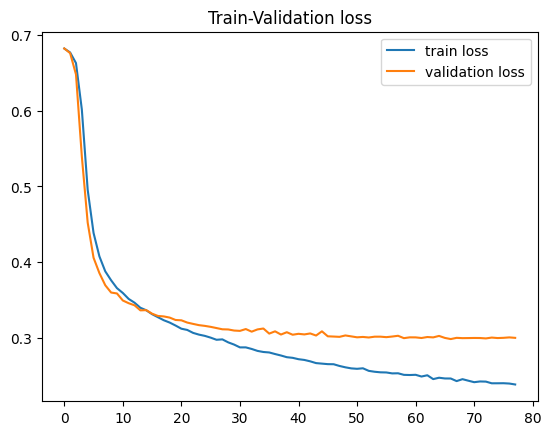

In [17]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path)

In [18]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using scikit learn accuracy por género en el conjunto about
GLOBAL: 0.8380102040816326
MALE 0.8333333333333334
FEMALE 0.8425 

Using scikit learn accuracy por género en el conjunto to
GLOBAL: 0.6553030303030303
MALE 0.6788321167883211
FEMALE 0.6299212598425197 

Using scikit learn accuracy por género en el conjunto as
GLOBAL: 0.6753585397653195
MALE 0.6590909090909091
FEMALE 0.692722371967655 



# TO

In [19]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='m1_distilbert_dep_pos_TO'

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.694886129076888 	 Validation loss: 0.6928499593573102 	 
  1%|          | 574/57400 [02:02<3:20:41,  4.72it/s]
Epoch 2 	 Training loss: 0.6942321089086633 	 Validation loss: 0.692422964815366 	 
  2%|▏         | 1148/57400 [04:10<4:42:51,  3.31it/s]
Epoch 3 	 Training loss: 0.694199254703854 	 Validation loss: 0.6930493490170624 	 
  3%|▎         | 1722/57400 [06:56<4:25:26,  3.50it/s]
Epoch 4 	 Training loss: 0.694178851120148 	 Validation loss: 0.6931685330504078 	 
  4%|▍         | 2296/57400 [09:44<3:55:31,  3.90it/s]
Epoch 5 	 Training loss: 0.6943656227937559 	 Validation loss: 0.6934286749969094 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [12:24<4:25:00,  3.43it/s]
Epoch 6 	 Training loss: 0.6940315770770614 	 Validation loss: 0.6940012109481682 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [15:32<4:16:35,  3.50it/s]
Epoch 7 	 Training loss: 0.6937829361975401 	 Validation loss: 0.6928747973199618 	 
  7%|▋         | 4018/

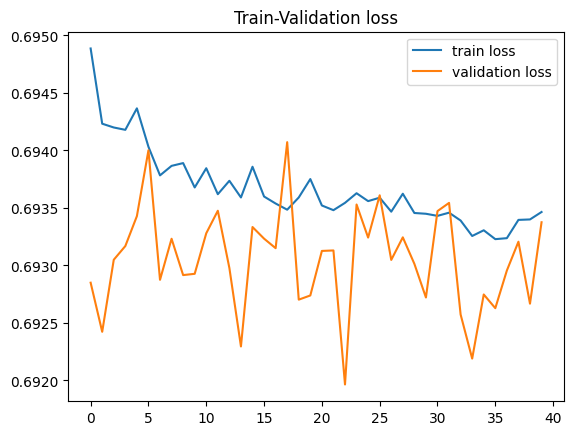

In [20]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path)

In [21]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using scikit learn accuracy por género en el conjunto about
GLOBAL: 0.45153061224489793
MALE 0.20052083333333334
FEMALE 0.6925 

Using scikit learn accuracy por género en el conjunto to
GLOBAL: 0.49242424242424243
MALE 0.15571776155717762
FEMALE 0.8556430446194225 

Using scikit learn accuracy por género en el conjunto as
GLOBAL: 0.4863102998696219
MALE 0.12626262626262627
FEMALE 0.8706199460916442 



# AS

In [22]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='m1_distilbert_dep_pos_AS'

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6951115539472693 	 Validation loss: 0.6933904855938281 	 
  1%|          | 574/57400 [02:35<4:08:18,  3.81it/s]
Epoch 2 	 Training loss: 0.6943982047278706 	 Validation loss: 0.692224541963157 	 
  2%|▏         | 1148/57400 [05:15<4:13:44,  3.69it/s]
Epoch 3 	 Training loss: 0.6940246353166029 	 Validation loss: 0.6929270190707708 	 
  3%|▎         | 1722/57400 [07:57<4:16:24,  3.62it/s]
Epoch 4 	 Training loss: 0.6941486746591974 	 Validation loss: 0.6922305711245132 	 
  4%|▍         | 2296/57400 [10:32<3:53:13,  3.94it/s]
Epoch 5 	 Training loss: 0.694073945180049 	 Validation loss: 0.6925602989681696 	 
  5%|▌         | 2870/57400 [13:18<5:08:47,  2.94it/s]
Epoch 6 	 Training loss: 0.6938096149873235 	 Validation loss: 0.6923582018431971 	 
  6%|▌         | 3444/57400 [16:10<3:04:45,  4.87it/s]
Epoch 7 	 Training loss: 0.6934105689517297 	 Validation loss: 0.6928467760651799 	 
  7%|▋         | 4018/57400 [18:44<3:07:42,  4.74it/s]
Epoch 8 	 Training loss

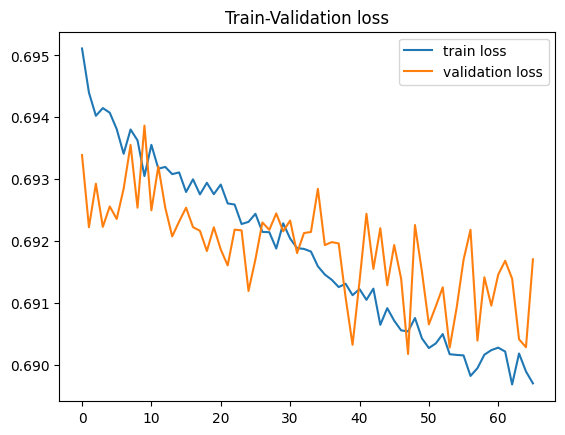

In [23]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path)

In [24]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using scikit learn accuracy por género en el conjunto about
GLOBAL: 0.6403061224489796
MALE 0.5885416666666666
FEMALE 0.69 

Using scikit learn accuracy por género en el conjunto to
GLOBAL: 0.5972222222222222
MALE 0.5571776155717761
FEMALE 0.6404199475065617 

Using scikit learn accuracy por género en el conjunto as
GLOBAL: 0.6075619295958279
MALE 0.4823232323232323
FEMALE 0.7412398921832885 

